In [2]:
import numpy as np
import os
import glob
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow import keras

import pathlib
import cv2 as cv

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn

In [3]:
print(tf.__version__)

2.5.0


<h1> Loading the images </h1>
<h2> Loading the training images </h2>
<h4> (Need better testing and training images) </h4>

Image loading section from https://www.tensorflow.org/tutorials/load_data/images

In [13]:
# Set a Path object pointing to the path of the training folder.
train_dir = pathlib.Path("ASL_Gestures/Train")

# Checking if all 87,000 images are loaded in the training set.
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

87000


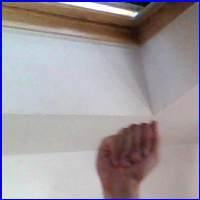

In [4]:
A = list(train_dir.glob('A/*'))
PIL.Image.open(str(A[0]))

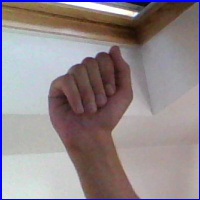

In [5]:
A = list(train_dir.glob('A/*'))
PIL.Image.open(str(A[1]))

<h2> Loading the Testing Images </h2>

In [12]:
# Set a Path object pointing to the path of the training folder.
test_dir = pathlib.Path("ASL_Gestures/Test/")

# Checking if all 28 images are loaded in the training set.
image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

28


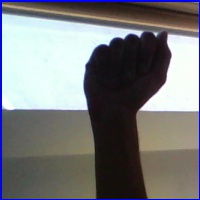

In [7]:
A = list(test_dir.glob('A/*.jpg'))
PIL.Image.open(str(A[0]))

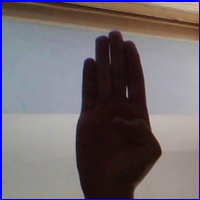

In [8]:
B = list(test_dir.glob('B/*.jpg'))
PIL.Image.open(str(B[0]))

In [9]:
X_test = []
y_test = []
files = glob.glob("ASL_Gestures/Test/*.jpg")
for file in files:
    image = cv.imread(file)
    baseName = os.path.basename(file)
    y_test.append(os.path.splitext(baseName)[0])
    X_test.append(image)

print('X_test shape:', np.array(X_test).shape)
print('Y_test:', y_test)

X_test shape: (0,)
Y_test: []


<h3> Creating datasets </h3>

Parameters

In [10]:
batch_size = 32
img_height = 200
img_width = 200

In [14]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 87000 files belonging to 29 classes.
Using 60900 files for training.


In [12]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 87000 files belonging to 29 classes.
Using 26100 files for validation.


In [15]:
class_names = train_dataset.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [14]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
)

Found 28 files belonging to 29 classes.


<h3> Visualize the data before moving on to modeling </h3>

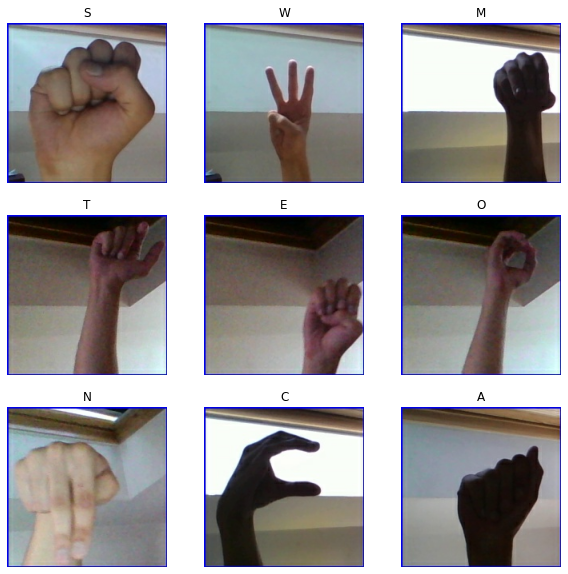

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")


In [16]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 29)


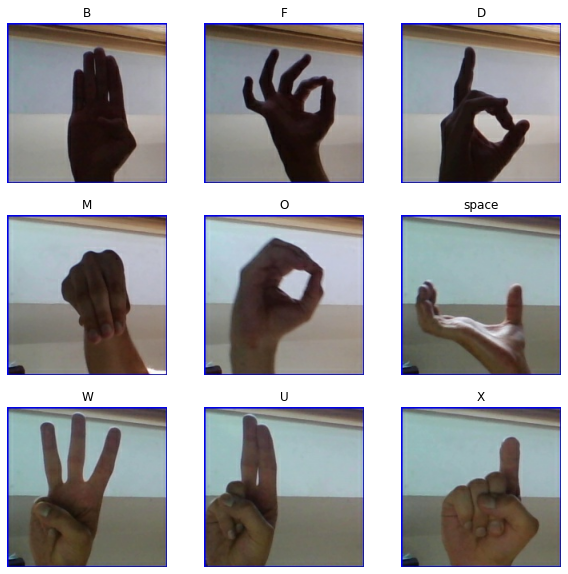

In [17]:
## Test Data Visualizations
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")

<h3> One-Hot Encode Data </h3>

In [18]:
# Get y labels for training
y_train = np.concatenate([y for x, y in train_dataset], axis=0)

# One-hot encode
y_train = tf.keras.utils.to_categorical(y_train, len(class_names))

In [19]:
# Get y labels for testing
y_test = np.concatenate([y for x,y in test_dataset], axis=0)

# One-hot encode
y_test = tf.keras.utils.to_categorical(y_test, len(class_names))

Rescale data

In [20]:
normalize_l = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

<h2> Training the Model </h2>

<h3>Transfer learning from a pre-trained model</h3>

In [21]:
# Training checkpoints 
class accuracyCheck95(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.95 and epoch >= 2):
            self.model.stop_training = True

callbacks_95 = accuracyCheck95()

<h3> Ignore for now </h3>

In [16]:
transfer = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(200,200,3), pooling='max', input_tensor=None)

In [18]:
net = transfer.output

In [19]:
# Adding top layers
net = layers.Flatten()(net)
net = layers.Activation('relu')(net)
net = layers.Dense(128)(net)
net = layers.Dropout(rate=0.5)(net)
output = layers.Dense(29)(net)

In [20]:
# Building the model
transfer_model = keras.Model(inputs=transfer.input, outputs=output)

In [21]:
# Make the transfer layers non-trainable (to make training quicker)
for layer in transfer.layers: layer.trainable = False

In [22]:
# Compiling the model

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Train the model
history_transfer = transfer_model.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=[callbacks_65])

<h3> Till Here, Ignore </h3>

In [55]:
num_classes = 29

model = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu', input_shape=(200,200,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.GlobalMaxPool2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax')
])


In [56]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [57]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [58]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=5,
  callbacks=[callbacks_95]
)

Epoch 1/5
/home/jaineelu/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
1904/1904 [==============================] - 693s 363ms/step - loss: 0.8077 - accuracy: 0.7680 - val_loss: 0.3537 - val_accuracy: 0.8793
Epoch 2/5
1904/1904 [==============================] - 685s 360ms/step - loss: 0.1646 - accuracy: 0.9469 - val_loss: 0.2877 - val_accuracy: 0.9059
Epoch 3/5
1904/1904 [==============================] - 698s 367ms/step - loss: 0.1091 - accuracy: 0.9640 - val_loss: 0.2401 - val_accuracy: 0.9183
Epoch 4/5
1904/1904 [==============================] - 695s 365ms/step - loss: 0.0873 - accuracy: 0.9711 - val_loss: 0.4919 - val_accuracy: 0.8503
Epoch 5/5
1904/1904 [==============================] - 698s 367ms/step - loss: 0.0712 - accur

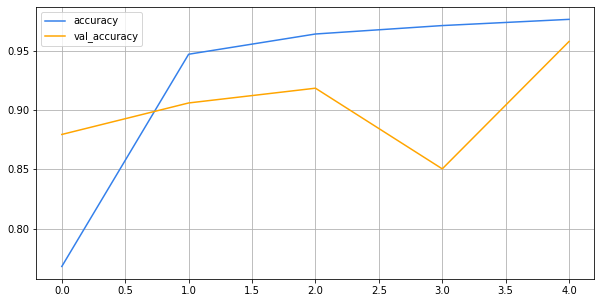

In [59]:

plt.figure(figsize=(10,5))

accuracy_label = 'accuracy'

acc_metric = history.history[accuracy_label]
val_acc_metric = history.history['val_'+accuracy_label]

num_epoch = range(0, len(acc_metric))

plt.plot(num_epoch, acc_metric, color='#3480eb')
plt.plot(num_epoch, val_acc_metric, color='orange')

plt.legend([accuracy_label, 'val_'+accuracy_label])

plt.grid()
plt.show()

<h4> Save Model </h4>

In [60]:
!mkdir -p asl_model_saved
model.save('asl_model_saved/asl_Model.h5')

Evaluate Model (Need to change to code from markup)

In [81]:
test_loss, test_acc = model.evaluate(test_dataset)

1/1 [==============================] - 0s 84ms/step - loss: 0.0107 - accuracy: 1.0000


shape :  (28, 29)
[12 16  7 19 15 20 24 25  4  2  6  3  1  0 21 14  8 13 23 18 26  5 27 11
  9 17  8 10 22]


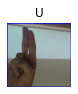

In [74]:
predictions = model.predict(test_dataset)
print('shape : ', predictions.shape)

for images, labels in test_dataset:
    for i in range(28):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")

classes = np.argmax(predictions, axis=0)
print(classes)
#for i in classes:
    #print(class_names[i])


<h2> Load Saved Pre-Trained Model </h2>

In [4]:
loaded_model = tf.keras.models.load_model('asl_model_saved/asl_Model.h5')

In [5]:
loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 32)       

<h3> Test with OpenCV and camera </h3>

In [50]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [51]:
file1 = open("test.txt", "a")

In [52]:
# Predict gesture
def predict_asl(img):
    img = img.reshape(1, 200, 200, 3)
    letter = class_names[np.argmax(loaded_model.predict(img))]
    if str(letter) != 'del' or str(letter) != 'nothing':
        if (str(letter)) == 'space':
            file1.write(' ')
        else:
            file1.write(str(letter))
    return letter

In [53]:
cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("Error : Camera cannot be opened")
    exit()
while True:
    #Capture frame-by-frame
    ret, frame = cap.read()
    
    # if frame is read correctly, ret is True
    if not ret:
        print ("Frame Error : Cannot receive frame.")
        break
    
    frame = cv.resize(frame, (200, 200), 3)
    label = predict_asl(frame)
    frame = cv.putText(frame, label, (50,50), cv.FONT_HERSHEY_COMPLEX, 1, (255,0,255), 1)
    cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('e'):
        break

# Release capture if exiting
cap.release()
cv.destroyAllWindows()
file1.close()